In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import AJA as aja
from torch_geometric.loader import DataLoader

In [2]:
# charge les data frame brut (avec bert par défaut mais on peut l'enlever)

df_train_nodes, df_train_edges, df_test_nodes, df_test_edges = aja.get_data()

In [3]:
df_train_nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72623 entries, 0 to 72622
Columns: 390 entries, transcription to bert_383
dtypes: float32(384), int64(3), object(3)
memory usage: 109.7+ MB


In [8]:
# on bricole ses data frame en définissant des fonction qui prennent en entré un dataframe
# et donne en sortie un dataframe
# c'est dans ces fonctions qu'on extrait les features 

# fonction d'extraction de feature pour les noeuds
def f(df):
    # il faut bien garder les colonnes 'transcription' 'line' et 'label
    # à part ces colonnes, toute colonne numérique dans le df rennvoyé sera utilisée comme feature
    return df

# fonction d'extraction de feature pour les arrêtes
def g(df):
    return df


In [5]:
# on crée les graphes de train, validation et test en donnant les fonctions d'feature-extraction
# de features et le ratio de validation (les vraies données de bases sont rechargées
# et la même transformation est appliquée au train et au test !) 

train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

In [6]:
# on check la forme des data
train_graphs
# ici les noeuds ont 386 features

{'TS3011b': Data(x=[985, 385], edge_index=[16], y=[985]),
 'TS3011c': Data(x=[1017, 385], edge_index=[16], y=[1017]),
 'TS3010c': Data(x=[689, 385], edge_index=[16], y=[689]),
 'ES2005a': Data(x=[126, 385], edge_index=[16], y=[126]),
 'IS1002b': Data(x=[782, 385], edge_index=[16], y=[782]),
 'IS1000d': Data(x=[1377, 385], edge_index=[16], y=[1377]),
 'ES2010d': Data(x=[563, 385], edge_index=[16], y=[563]),
 'IS1006c': Data(x=[870, 385], edge_index=[16], y=[870]),
 'ES2016d': Data(x=[647, 385], edge_index=[16], y=[647]),
 'TS3009b': Data(x=[1207, 385], edge_index=[16], y=[1207]),
 'IS1004b': Data(x=[672, 385], edge_index=[16], y=[672]),
 'ES2006a': Data(x=[403, 385], edge_index=[16], y=[403]),
 'IS1003c': Data(x=[869, 385], edge_index=[16], y=[869]),
 'TS3008d': Data(x=[1328, 385], edge_index=[16], y=[1328]),
 'IS1004c': Data(x=[839, 385], edge_index=[16], y=[839]),
 'IS1006a': Data(x=[357, 385], edge_index=[16], y=[357]),
 'ES2012d': Data(x=[450, 385], edge_index=[16], y=[450]),
 'IS10

In [9]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.channels = channels
        self.sc1 = 40
        self.f1 = 50
        self.sc2 = 30
        self.GCN1 = nn.ModuleList([GCNConv(input_dim, self.sc1) for _ in range(channels)])
        self.dense1 = nn.Linear(self.sc1*channels, self.f1)
        self.GCN2 = nn.ModuleList([GCNConv(self.f1, self.sc2) for _ in range(channels)])
        self.dense2 = nn.Linear(self.sc2*channels, 2)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        # Appliquez les couches GCN avec une activation ReLU entre elles
        x1 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc1)
            else:
                x = F.relu(self.GCN1[k](nodes, edges[k]))
            x1.append(x)
        x1_f = torch.cat(x1, dim=1)

        f1 = F.relu(self.dense1(x1_f))

        x2 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc2)
            else:
                x = F.relu(self.GCN2[k](f1, edges[k]))
            x1.append(x)
            x2.append(x)
        x2_f = torch.cat(x2, dim=1)

        x_out = self.dense2(x2_f)

        return F.log_softmax(x_out, dim=1)

In [49]:
# on instancie le modèle
model = NodeClassifier(16,385)

# on définie la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# on entraine !

states = []

for epoch in range(7):
    loss = aja.train(model, train_graphs, optimizer, criterion)
    print('- Epoch', f'{epoch:03d}', '-')
    print('Loss:',  f'{loss:.4f}')
    f1_train = aja.f1_score_moyen(model, train_graphs)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    print('F1 train:', f1_train)
    print('F1 valid:', f1_valid)
    torch.save(model.state_dict(), "training_states/"+str(epoch) + ".pth")
    print('')

- Epoch 000 -
Loss: 26.1271
F1 train: 0.2937271610642893
F1 valid: 0.2812595479312178
- Epoch 001 -
Loss: 24.7341
F1 train: 0.4777685866171371
F1 valid: 0.444481501715708
- Epoch 002 -
Loss: 23.3626
F1 train: 0.47310011479017494
F1 valid: 0.42265849152819157
- Epoch 003 -
Loss: 22.5654
F1 train: 0.47952921635560675
F1 valid: 0.40420766986416995
- Epoch 004 -
Loss: 21.8487
F1 train: 0.41163207334978175
F1 valid: 0.3259058058169982
- Epoch 005 -
Loss: 21.2873
F1 train: 0.6239182820799346
F1 valid: 0.5105740382269702
- Epoch 006 -
Loss: 20.1744
F1 train: 0.6177888063112088
F1 valid: 0.4890510194046625


-------------------------
Analyse des performance du modèle :
-------------------------
F1-score: 0.5105740382269702


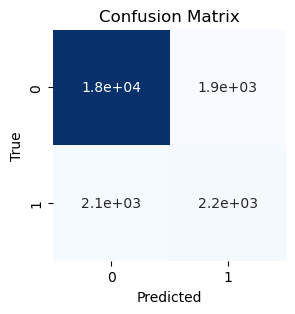

In [50]:
model_final = NodeClassifier(16,385)

# on peut revenir à un modèle intermédiaire pour éviter l'overfitting
epoch_opt = 5
model_final.load_state_dict(torch.load("training_states/"+str(epoch_opt)+".pth"))

# on analyse le modèle
aja.analyse_model(model_final, validation_graphs)

In [51]:
# quand on est content on fait une submission !

aja.make_test_csv_submission(model_final, test_graphs, 'early_stopping')